# Proyecto Módulo 2: Clasificación de Géneros de Películas con Modelos de Tópicos

**Maestría MACC — Aplicaciones de Aprendizaje de Máquina 2025-1**
**Profesor: Nicolás López**
**Estudiante: Naigel Herrera Lombana**
---

### 1. Objetivo y Metodología

El objetivo de este proyecto es construir un sistema de clasificación que pueda predecir el género de una película basándose únicamente en el texto de su sinopsis (*overview*). Para lograr esto, no utilizaremos el texto directamente, sino que aplicaremos técnicas de modelado estadístico para representarlo de una manera más significativa.

La metodología a seguir es:
1.  **Modelado de Tópicos con LDA (Latent Dirichlet Allocation):** Primero, usaremos LDA para descubrir los "temas" latentes presentes en el conjunto de todas las sinopsis. Cada sinopsis será representada no por sus palabras, sino por la distribución de probabilidad de estos temas.
2.  **Generación de Embeddings:** La distribución de temas de cada sinopsis servirá como un vector de características denso (un *embedding*).
3.  **Clasificación Supervisada:** Finalmente, estos embeddings se utilizarán como entrada para un modelo de regresión logística que aprenderá a predecir si una película pertenece a un género específico.


---

### 2. Preparación del Entorno
Comenzamos importando todas las librerías que necesitaremos para el análisis, incluyendo `pandas` para la manipulación de datos, `sklearn` para el preprocesamiento y modelado, y `lda` para el modelado de tópicos.

In [1]:
#Realizamos importaciones necesarias
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns

# Text processing and modeling
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, accuracy_score
from sklearn.pipeline import Pipeline

# Text splitter para verificar la longitud de las sinopsis
from langchain.text_splitter import SentenceTransformersTokenTextSplitter

# LDA model
import lda

---

### 3. Carga y Preprocesamiento de Datos

La calidad de los datos es fundamental. En esta fase, cargamos el dataset, lo limpiamos y lo filtramos para adecuarlo a los requisitos del problema.

#### 3.1. Carga y Procesamiento de Géneros
Cargamos el archivo `movies_metadata.csv`. La columna `genres` está en un formato de texto que parece JSON, por lo que la procesamos para extraer una lista limpia de nombres de género. Para simplificar el problema y convertirlo en una clasificación multiclase (y posteriormente binaria), filtramos el dataset para quedarnos solo con las películas que tienen **exactamente un género** asignado.

In [2]:
# Cargar los datos
df = pd.read_csv("movies_metadata.csv", low_memory=False)

# Convertir la columna 'genres' de string a lista de diccionarios
# Se usa ast.literal_eval para una evaluación segura del string
df['genres_parsed'] = df['genres'].apply(ast.literal_eval)

# Extraer solo el nombre de cada género
df['genres'] = df['genres_parsed'].apply(lambda x: [genre['name'] for genre in x])

# Filtrar películas que tienen exactamente un género
df['len']= df['genres'].apply(lambda x: len(x))
df_movies= df[df['len'] == 1].copy()

# Limpiar filas sin 'overview' o 'title'
df_movies = df_movies.dropna(subset=['overview', 'title'])

# Extraer el único género de la lista
df_movies['genres'] = df_movies['genres'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)

#### 3.2. Filtrado por Géneros Válidos y Longitud de Sinopsis

De acuerdo con las especificaciones del proyecto, nos enfocamos en un conjunto específico de 12 géneros. Adicionalmente, para asegurar que los textos de las sinopsis no sean demasiado largos para ser procesados eficientemente, verificamos su longitud. Usando un `SentenceTransformersTokenTextSplitter`, calculamos cuántos fragmentos (`chunks`) se necesitarían para cada sinopsis y **conservamos solo aquellas que caben en un único fragmento**. Esto nos permite tratar cada sinopsis como un solo documento.

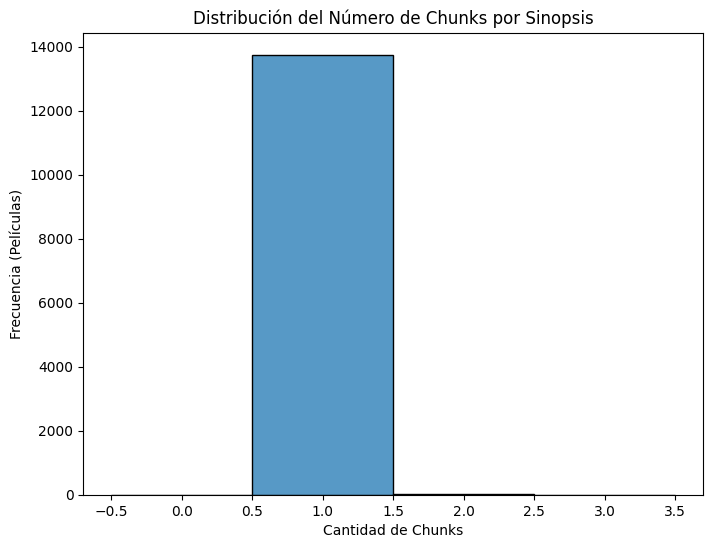

Número de observaciones después del filtrado final: 13745


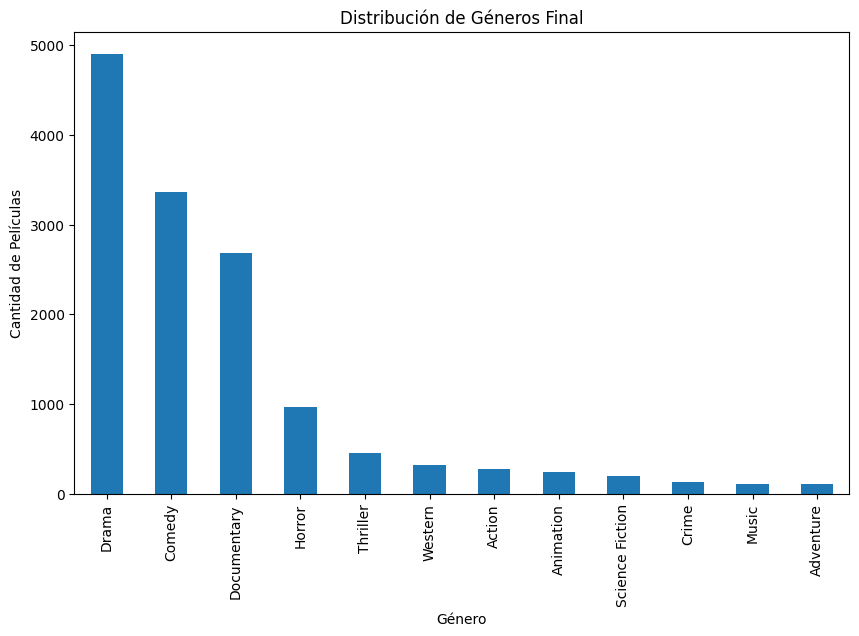

In [3]:
# Lista de géneros válidos según las especificaciones
generos_validos = ['Comedy', 'Drama', 'Documentary', 'Crime', 'Adventure', 'Science Fiction', 'Thriller', 'Horror', 'Animation', 'Action', 'Western', 'Music']
df_filtered = df_movies[df_movies['genres'].isin(generos_validos)].copy()

# Inicializar el text splitter para verificar la longitud de las sinopsis
text_splitter = SentenceTransformersTokenTextSplitter(
    model_name="sentence-transformers/all-MiniLM-L6-v2",
    chunk_size=512, # Longitud máxima teórica del modelo
    chunk_overlap=0,
)

# Calcular el número de chunks para cada 'overview'
df_filtered['n_chunks'] = df_filtered['overview'].apply(lambda x: len(text_splitter.split_text(str(x))))

# Histograma para visualizar la distribución de chunks
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(df_filtered['n_chunks'], ax=ax, discrete=True)
ax.set_title('Distribución del Número de Chunks por Sinopsis')
ax.set_xlabel('Cantidad de Chunks')
ax.set_ylabel('Frecuencia (Películas)')
plt.show()

# Filtrar para conservar solo las películas con un único chunk
df_final = df_filtered[df_filtered['n_chunks'] == 1].copy()

# Seleccionar las columnas finales y mostrar la distribución
df_final = df_final[['title', 'overview', 'genres']].copy()
print(f"Número de observaciones después del filtrado final: {len(df_final)}")
df_final['genres'].value_counts().plot(kind='bar', figsize=(10, 6), title='Distribución de Géneros Final')
plt.xlabel('Género')
plt.ylabel('Cantidad de Películas')
plt.show()

#### 3.3. Preparación de Datos para Clasificación Binaria

Para cumplir con el objetivo de entrenar un clasificador, definimos una tarea binaria: predecir si una película pertenece al género **"Action"** (clase positiva, `1`) o no (clase negativa, `0`). Luego, dividimos nuestros datos en conjuntos de entrenamiento (80%) y prueba (20%), asegurando que la proporción de ambas clases se mantenga en ambos conjuntos mediante la estratificación.

In [4]:
# Variable objetivo (target): 1 si es 'Action', 0 en otro caso
df_final['is_action'] = (df_final['genres'] == 'Action').astype(int)

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    df_final['overview'], 
    df_final['is_action'], 
    test_size=0.2, 
    random_state=42,
    stratify=df_final['is_action'] # Estratificar para mantener la proporción
)

print(f"Tamaño del conjunto de entrenamiento: {len(X_train)} muestras")
print(f"Tamaño del conjunto de prueba: {len(X_test)} muestras")

Tamaño del conjunto de entrenamiento: 10996 muestras
Tamaño del conjunto de prueba: 2749 muestras


---
### 4. Búsqueda del Número Óptimo de Temas (p)

Un hiperparámetro crucial en LDA es el número de temas (`p`). Para encontrar el `p` óptimo para nuestra tarea, realizaremos una **validación cruzada de 5 folds**. Para cada valor de `p` entre 10 y 20, entrenaremos un modelo LDA y luego un clasificador de Regresión Logística sobre los temas resultantes, evaluando con **AUC-ROC**. El `p` con el mejor AUC promedio será el elegido.

INFO:lda:n_documents: 10996
INFO:lda:vocab_size: 1000
INFO:lda:n_words: 149840
INFO:lda:n_topics: 10
INFO:lda:n_iter: 1000


Iniciando búsqueda del número óptimo de temas (p)...


INFO:lda:<0> log likelihood: -1513933
INFO:lda:<10> log likelihood: -1161790
INFO:lda:<20> log likelihood: -1122505
INFO:lda:<30> log likelihood: -1106218
INFO:lda:<40> log likelihood: -1097853
INFO:lda:<50> log likelihood: -1092496
INFO:lda:<60> log likelihood: -1088541
INFO:lda:<70> log likelihood: -1084745
INFO:lda:<80> log likelihood: -1082967
INFO:lda:<90> log likelihood: -1080098
INFO:lda:<100> log likelihood: -1079276
INFO:lda:<110> log likelihood: -1078605
INFO:lda:<120> log likelihood: -1076905
INFO:lda:<130> log likelihood: -1075334
INFO:lda:<140> log likelihood: -1075243
INFO:lda:<150> log likelihood: -1074008
INFO:lda:<160> log likelihood: -1073548
INFO:lda:<170> log likelihood: -1072825
INFO:lda:<180> log likelihood: -1072396
INFO:lda:<190> log likelihood: -1072498
INFO:lda:<200> log likelihood: -1071957
INFO:lda:<210> log likelihood: -1072270
INFO:lda:<220> log likelihood: -1072363
INFO:lda:<230> log likelihood: -1071247
INFO:lda:<240> log likelihood: -1071147
INFO:lda:<2

p = 10, AUC Promedio (CV=5) = 0.7949


INFO:lda:<0> log likelihood: -1538995
INFO:lda:<10> log likelihood: -1168848
INFO:lda:<20> log likelihood: -1126088
INFO:lda:<30> log likelihood: -1109066
INFO:lda:<40> log likelihood: -1100904
INFO:lda:<50> log likelihood: -1094477
INFO:lda:<60> log likelihood: -1090867
INFO:lda:<70> log likelihood: -1086678
INFO:lda:<80> log likelihood: -1083767
INFO:lda:<90> log likelihood: -1083205
INFO:lda:<100> log likelihood: -1081744
INFO:lda:<110> log likelihood: -1080570
INFO:lda:<120> log likelihood: -1078869
INFO:lda:<130> log likelihood: -1077942
INFO:lda:<140> log likelihood: -1076733
INFO:lda:<150> log likelihood: -1076115
INFO:lda:<160> log likelihood: -1075904
INFO:lda:<170> log likelihood: -1075456
INFO:lda:<180> log likelihood: -1075142
INFO:lda:<190> log likelihood: -1074831
INFO:lda:<200> log likelihood: -1074667
INFO:lda:<210> log likelihood: -1074676
INFO:lda:<220> log likelihood: -1074820
INFO:lda:<230> log likelihood: -1073980
INFO:lda:<240> log likelihood: -1073798
INFO:lda:<2

p = 11, AUC Promedio (CV=5) = 0.7898


INFO:lda:<0> log likelihood: -1561665
INFO:lda:<10> log likelihood: -1171153
INFO:lda:<20> log likelihood: -1129707
INFO:lda:<30> log likelihood: -1112576
INFO:lda:<40> log likelihood: -1104092
INFO:lda:<50> log likelihood: -1098367
INFO:lda:<60> log likelihood: -1095083
INFO:lda:<70> log likelihood: -1091914
INFO:lda:<80> log likelihood: -1089572
INFO:lda:<90> log likelihood: -1089063
INFO:lda:<100> log likelihood: -1086503
INFO:lda:<110> log likelihood: -1085262
INFO:lda:<120> log likelihood: -1083385
INFO:lda:<130> log likelihood: -1083373
INFO:lda:<140> log likelihood: -1082225
INFO:lda:<150> log likelihood: -1081575
INFO:lda:<160> log likelihood: -1080632
INFO:lda:<170> log likelihood: -1079789
INFO:lda:<180> log likelihood: -1079113
INFO:lda:<190> log likelihood: -1079065
INFO:lda:<200> log likelihood: -1078466
INFO:lda:<210> log likelihood: -1077499
INFO:lda:<220> log likelihood: -1078021
INFO:lda:<230> log likelihood: -1077079
INFO:lda:<240> log likelihood: -1076344
INFO:lda:<2

p = 12, AUC Promedio (CV=5) = 0.7988


INFO:lda:<0> log likelihood: -1582341
INFO:lda:<10> log likelihood: -1174962
INFO:lda:<20> log likelihood: -1130340
INFO:lda:<30> log likelihood: -1114421
INFO:lda:<40> log likelihood: -1103933
INFO:lda:<50> log likelihood: -1099076
INFO:lda:<60> log likelihood: -1094920
INFO:lda:<70> log likelihood: -1091584
INFO:lda:<80> log likelihood: -1088175
INFO:lda:<90> log likelihood: -1087579
INFO:lda:<100> log likelihood: -1085244
INFO:lda:<110> log likelihood: -1084595
INFO:lda:<120> log likelihood: -1082897
INFO:lda:<130> log likelihood: -1083042
INFO:lda:<140> log likelihood: -1081641
INFO:lda:<150> log likelihood: -1079894
INFO:lda:<160> log likelihood: -1078939
INFO:lda:<170> log likelihood: -1078297
INFO:lda:<180> log likelihood: -1077888
INFO:lda:<190> log likelihood: -1077992
INFO:lda:<200> log likelihood: -1077773
INFO:lda:<210> log likelihood: -1076161
INFO:lda:<220> log likelihood: -1076363
INFO:lda:<230> log likelihood: -1076318
INFO:lda:<240> log likelihood: -1076108
INFO:lda:<2

p = 13, AUC Promedio (CV=5) = 0.8142


INFO:lda:<0> log likelihood: -1601482
INFO:lda:<10> log likelihood: -1182472
INFO:lda:<20> log likelihood: -1138338
INFO:lda:<30> log likelihood: -1118741
INFO:lda:<40> log likelihood: -1106915
INFO:lda:<50> log likelihood: -1100755
INFO:lda:<60> log likelihood: -1096925
INFO:lda:<70> log likelihood: -1092136
INFO:lda:<80> log likelihood: -1089381
INFO:lda:<90> log likelihood: -1086787
INFO:lda:<100> log likelihood: -1086232
INFO:lda:<110> log likelihood: -1084912
INFO:lda:<120> log likelihood: -1083106
INFO:lda:<130> log likelihood: -1083074
INFO:lda:<140> log likelihood: -1081152
INFO:lda:<150> log likelihood: -1080967
INFO:lda:<160> log likelihood: -1080364
INFO:lda:<170> log likelihood: -1079056
INFO:lda:<180> log likelihood: -1079698
INFO:lda:<190> log likelihood: -1079483
INFO:lda:<200> log likelihood: -1078125
INFO:lda:<210> log likelihood: -1077787
INFO:lda:<220> log likelihood: -1077916
INFO:lda:<230> log likelihood: -1078266
INFO:lda:<240> log likelihood: -1077041
INFO:lda:<2

p = 14, AUC Promedio (CV=5) = 0.8132


INFO:lda:<0> log likelihood: -1618984
INFO:lda:<10> log likelihood: -1183786
INFO:lda:<20> log likelihood: -1138782
INFO:lda:<30> log likelihood: -1121198
INFO:lda:<40> log likelihood: -1111195
INFO:lda:<50> log likelihood: -1104580
INFO:lda:<60> log likelihood: -1100642
INFO:lda:<70> log likelihood: -1097381
INFO:lda:<80> log likelihood: -1094985
INFO:lda:<90> log likelihood: -1093041
INFO:lda:<100> log likelihood: -1089393
INFO:lda:<110> log likelihood: -1089001
INFO:lda:<120> log likelihood: -1087149
INFO:lda:<130> log likelihood: -1086195
INFO:lda:<140> log likelihood: -1085045
INFO:lda:<150> log likelihood: -1084081
INFO:lda:<160> log likelihood: -1083405
INFO:lda:<170> log likelihood: -1082249
INFO:lda:<180> log likelihood: -1081313
INFO:lda:<190> log likelihood: -1081100
INFO:lda:<200> log likelihood: -1080686
INFO:lda:<210> log likelihood: -1079874
INFO:lda:<220> log likelihood: -1079924
INFO:lda:<230> log likelihood: -1080507
INFO:lda:<240> log likelihood: -1079401
INFO:lda:<2

p = 15, AUC Promedio (CV=5) = 0.7982


INFO:lda:<0> log likelihood: -1634973
INFO:lda:<10> log likelihood: -1191445
INFO:lda:<20> log likelihood: -1141262
INFO:lda:<30> log likelihood: -1122523
INFO:lda:<40> log likelihood: -1112129
INFO:lda:<50> log likelihood: -1105985
INFO:lda:<60> log likelihood: -1101611
INFO:lda:<70> log likelihood: -1098641
INFO:lda:<80> log likelihood: -1095703
INFO:lda:<90> log likelihood: -1094144
INFO:lda:<100> log likelihood: -1092301
INFO:lda:<110> log likelihood: -1091054
INFO:lda:<120> log likelihood: -1089107
INFO:lda:<130> log likelihood: -1088160
INFO:lda:<140> log likelihood: -1088054
INFO:lda:<150> log likelihood: -1086568
INFO:lda:<160> log likelihood: -1085109
INFO:lda:<170> log likelihood: -1085464
INFO:lda:<180> log likelihood: -1084641
INFO:lda:<190> log likelihood: -1084779
INFO:lda:<200> log likelihood: -1084463
INFO:lda:<210> log likelihood: -1084526
INFO:lda:<220> log likelihood: -1083376
INFO:lda:<230> log likelihood: -1083028
INFO:lda:<240> log likelihood: -1082822
INFO:lda:<2

p = 16, AUC Promedio (CV=5) = 0.8091


INFO:lda:<0> log likelihood: -1649753
INFO:lda:<10> log likelihood: -1193026
INFO:lda:<20> log likelihood: -1144796
INFO:lda:<30> log likelihood: -1125281
INFO:lda:<40> log likelihood: -1114308
INFO:lda:<50> log likelihood: -1107293
INFO:lda:<60> log likelihood: -1103705
INFO:lda:<70> log likelihood: -1099819
INFO:lda:<80> log likelihood: -1096595
INFO:lda:<90> log likelihood: -1094847
INFO:lda:<100> log likelihood: -1093653
INFO:lda:<110> log likelihood: -1092090
INFO:lda:<120> log likelihood: -1091255
INFO:lda:<130> log likelihood: -1090392
INFO:lda:<140> log likelihood: -1088485
INFO:lda:<150> log likelihood: -1088539
INFO:lda:<160> log likelihood: -1086576
INFO:lda:<170> log likelihood: -1086304
INFO:lda:<180> log likelihood: -1087246
INFO:lda:<190> log likelihood: -1085313
INFO:lda:<200> log likelihood: -1086172
INFO:lda:<210> log likelihood: -1085355
INFO:lda:<220> log likelihood: -1084952
INFO:lda:<230> log likelihood: -1084865
INFO:lda:<240> log likelihood: -1084383
INFO:lda:<2

p = 17, AUC Promedio (CV=5) = 0.8065


INFO:lda:<0> log likelihood: -1662911
INFO:lda:<10> log likelihood: -1198291
INFO:lda:<20> log likelihood: -1148289
INFO:lda:<30> log likelihood: -1127424
INFO:lda:<40> log likelihood: -1115507
INFO:lda:<50> log likelihood: -1107855
INFO:lda:<60> log likelihood: -1103998
INFO:lda:<70> log likelihood: -1100694
INFO:lda:<80> log likelihood: -1098282
INFO:lda:<90> log likelihood: -1095577
INFO:lda:<100> log likelihood: -1094253
INFO:lda:<110> log likelihood: -1092636
INFO:lda:<120> log likelihood: -1091792
INFO:lda:<130> log likelihood: -1090384
INFO:lda:<140> log likelihood: -1089016
INFO:lda:<150> log likelihood: -1088667
INFO:lda:<160> log likelihood: -1088442
INFO:lda:<170> log likelihood: -1087898
INFO:lda:<180> log likelihood: -1087368
INFO:lda:<190> log likelihood: -1086739
INFO:lda:<200> log likelihood: -1086349
INFO:lda:<210> log likelihood: -1086086
INFO:lda:<220> log likelihood: -1085588
INFO:lda:<230> log likelihood: -1083997
INFO:lda:<240> log likelihood: -1084986
INFO:lda:<2

p = 18, AUC Promedio (CV=5) = 0.8061


INFO:lda:<0> log likelihood: -1675677
INFO:lda:<10> log likelihood: -1202460
INFO:lda:<20> log likelihood: -1151303
INFO:lda:<30> log likelihood: -1130092
INFO:lda:<40> log likelihood: -1118087
INFO:lda:<50> log likelihood: -1111477
INFO:lda:<60> log likelihood: -1106847
INFO:lda:<70> log likelihood: -1102665
INFO:lda:<80> log likelihood: -1100336
INFO:lda:<90> log likelihood: -1097627
INFO:lda:<100> log likelihood: -1095973
INFO:lda:<110> log likelihood: -1094024
INFO:lda:<120> log likelihood: -1092023
INFO:lda:<130> log likelihood: -1090989
INFO:lda:<140> log likelihood: -1090331
INFO:lda:<150> log likelihood: -1089258
INFO:lda:<160> log likelihood: -1087340
INFO:lda:<170> log likelihood: -1087896
INFO:lda:<180> log likelihood: -1086379
INFO:lda:<190> log likelihood: -1086350
INFO:lda:<200> log likelihood: -1086035
INFO:lda:<210> log likelihood: -1085375
INFO:lda:<220> log likelihood: -1085581
INFO:lda:<230> log likelihood: -1084673
INFO:lda:<240> log likelihood: -1084550
INFO:lda:<2

p = 19, AUC Promedio (CV=5) = 0.8129


INFO:lda:<0> log likelihood: -1687285
INFO:lda:<10> log likelihood: -1206529
INFO:lda:<20> log likelihood: -1151001
INFO:lda:<30> log likelihood: -1128934
INFO:lda:<40> log likelihood: -1118756
INFO:lda:<50> log likelihood: -1111054
INFO:lda:<60> log likelihood: -1106400
INFO:lda:<70> log likelihood: -1102565
INFO:lda:<80> log likelihood: -1100564
INFO:lda:<90> log likelihood: -1096566
INFO:lda:<100> log likelihood: -1095361
INFO:lda:<110> log likelihood: -1094757
INFO:lda:<120> log likelihood: -1093539
INFO:lda:<130> log likelihood: -1091622
INFO:lda:<140> log likelihood: -1090933
INFO:lda:<150> log likelihood: -1090032
INFO:lda:<160> log likelihood: -1089408
INFO:lda:<170> log likelihood: -1088890
INFO:lda:<180> log likelihood: -1088345
INFO:lda:<190> log likelihood: -1087610
INFO:lda:<200> log likelihood: -1087351
INFO:lda:<210> log likelihood: -1086669
INFO:lda:<220> log likelihood: -1086912
INFO:lda:<230> log likelihood: -1085866
INFO:lda:<240> log likelihood: -1084521
INFO:lda:<2

p = 20, AUC Promedio (CV=5) = 0.8198

Número óptimo de temas (p) encontrado: 20


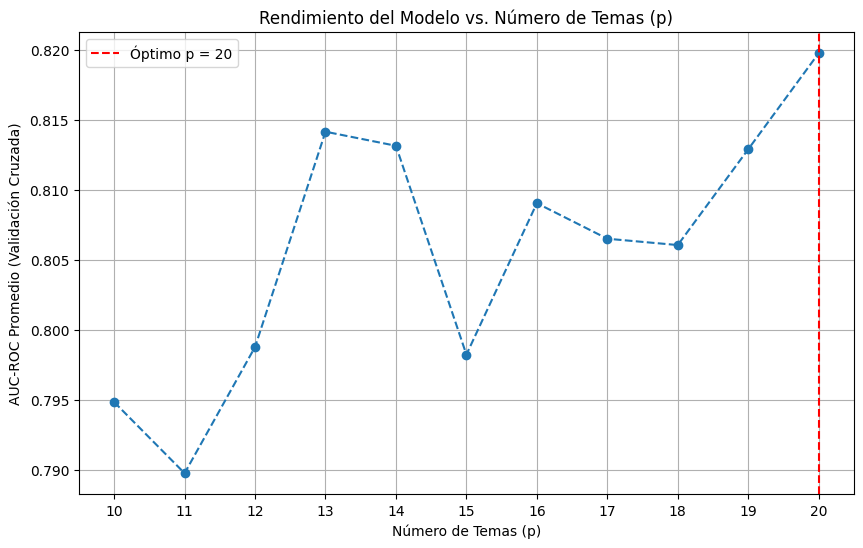

In [5]:
# Vectorizador de Frecuencia de Palabras (Bag of Words)
vectorizer = CountVectorizer(stop_words='english', 
                             max_df=0.95, 
                             min_df=2,
                             max_features=1000)

# Ajustar y transformar los datos de entrenamiento
X_train_bow = vectorizer.fit_transform(X_train)

# Rango de número de temas a evaluar
topic_range = range(10, 21)
mean_auc_scores = []

print("Iniciando búsqueda del número óptimo de temas (p)...")

# Iterar sobre cada valor de p
for p in topic_range:
    # Modelo LDA
    lda_model_cv = lda.LDA(n_topics=p, n_iter=1000, random_state=42)
    X_train_topics_cv = lda_model_cv.fit_transform(X_train_bow)
    
    # Clasificador de Regresión Logística
    log_reg_cv = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')
    
    # Validación cruzada de 5-folds
    cv_scores = cross_val_score(log_reg_cv, X_train_topics_cv, y_train, cv=5, scoring='roc_auc')
    
    mean_auc_scores.append(np.mean(cv_scores))
    print(f"p = {p}, AUC Promedio (CV=5) = {np.mean(cv_scores):.4f}")

# Encontrar el número óptimo de temas
optimal_p = topic_range[np.argmax(mean_auc_scores)]
print(f"\nNúmero óptimo de temas (p) encontrado: {optimal_p}")

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(topic_range, mean_auc_scores, marker='o', linestyle='--')
plt.title('Rendimiento del Modelo vs. Número de Temas (p)')
plt.xlabel('Número de Temas (p)')
plt.ylabel('AUC-ROC Promedio (Validación Cruzada)')
plt.xticks(topic_range)
plt.axvline(x=optimal_p, color='r', linestyle='--', label=f'Óptimo p = {optimal_p}')
plt.legend()
plt.grid(True)
plt.show()

---
### 5. Evaluación del Modelo Seleccionado

Con el número óptimo de temas (`p`) ya definido, ahora evaluamos el rendimiento final del modelo de manera más rigurosa, utilizando una **validación cruzada de 10 folds**. Esto nos dará una estimación más estable de su comportamiento en datos no vistos.

In [6]:
p_final = optimal_p 

# El pipeline manual para cada fold
kf = KFold(n_splits=10, shuffle=True, random_state=42)
auc_scores_10fold = []
vectorizer_eval = CountVectorizer(stop_words='english', max_df=0.95, min_df=2, max_features=1000)

X = df_final['overview']
y = df_final['is_action']

print(f"Evaluando el modelo final con p={p_final} usando 10-fold CV...")

for train_index, test_index in kf.split(X):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    
    # Vectorizar
    X_train_bow_fold = vectorizer_eval.fit_transform(X_train_fold)
    X_test_bow_fold = vectorizer_eval.transform(X_test_fold)
    
    # LDA
    lda_model_fold = lda.LDA(n_topics=p_final, n_iter=1000, random_state=42)
    lda_model_fold.fit(X_train_bow_fold)
    X_train_topics_fold = lda_model_fold.transform(X_train_bow_fold)
    X_test_topics_fold = lda_model_fold.transform(X_test_bow_fold)
    
    # Clasificador
    log_reg_fold = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')
    log_reg_fold.fit(X_train_topics_fold, y_train_fold)
    
    # Predecir probabilidades y calcular AUC
    y_pred_proba = log_reg_fold.predict_proba(X_test_topics_fold)[:, 1]
    auc_scores_10fold.append(roc_auc_score(y_test_fold, y_pred_proba))

print(f"\nResultados de la Validación Cruzada (10-folds):")
print(f"Scores AUC: {[round(score, 4) for score in auc_scores_10fold]}")
print(f"AUC Promedio: {np.mean(auc_scores_10fold):.4f}")
print(f"Desviación Estándar del AUC: {np.std(auc_scores_10fold):.4f}")

Evaluando el modelo final con p=20 usando 10-fold CV...


INFO:lda:n_documents: 12370
INFO:lda:vocab_size: 1000
INFO:lda:n_words: 168798
INFO:lda:n_topics: 20
INFO:lda:n_iter: 1000
INFO:lda:<0> log likelihood: -1892865
INFO:lda:<10> log likelihood: -1361282
INFO:lda:<20> log likelihood: -1299833
INFO:lda:<30> log likelihood: -1274163
INFO:lda:<40> log likelihood: -1261586
INFO:lda:<50> log likelihood: -1253854
INFO:lda:<60> log likelihood: -1249473
INFO:lda:<70> log likelihood: -1245632
INFO:lda:<80> log likelihood: -1242079
INFO:lda:<90> log likelihood: -1239779
INFO:lda:<100> log likelihood: -1237781
INFO:lda:<110> log likelihood: -1235493
INFO:lda:<120> log likelihood: -1234822
INFO:lda:<130> log likelihood: -1233728
INFO:lda:<140> log likelihood: -1232531
INFO:lda:<150> log likelihood: -1231320
INFO:lda:<160> log likelihood: -1230670
INFO:lda:<170> log likelihood: -1230590
INFO:lda:<180> log likelihood: -1229546
INFO:lda:<190> log likelihood: -1228999
INFO:lda:<200> log likelihood: -1227981
INFO:lda:<210> log likelihood: -1226910
INFO:lda


Resultados de la Validación Cruzada (10-folds):
Scores AUC: [0.8083, 0.8388, 0.8096, 0.8347, 0.8242, 0.8127, 0.8112, 0.8767, 0.8496, 0.857]
AUC Promedio: 0.8323
Desviación Estándar del AUC: 0.0222


---
### 6. Entrenamiento Final e Interpretación de Resultados
Ahora, entrenamos nuestro modelo final utilizando todos los datos de entrenamiento y el número óptimo de temas. Posteriormente, interpretamos los resultados para entender qué ha aprendido el modelo.

#### 6.1. Entrenamiento del Modelo Final

In [7]:
# Entrenamos el pipeline completo sobre el conjunto de entrenamiento original
vectorizer_final = CountVectorizer(stop_words='english', max_df=0.95, min_df=2, max_features=1000)
X_train_bow_final = vectorizer_final.fit_transform(X_train)
vocab = vectorizer_final.get_feature_names_out()

lda_model_final = lda.LDA(n_topics=optimal_p, n_iter=1500, random_state=42)
X_train_topics_final = lda_model_final.fit_transform(X_train_bow_final)

classifier_final = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')
classifier_final.fit(X_train_topics_final, y_train)

print("Modelo final entrenado.")

INFO:lda:n_documents: 10996
INFO:lda:vocab_size: 1000
INFO:lda:n_words: 149840
INFO:lda:n_topics: 20
INFO:lda:n_iter: 1500
INFO:lda:<0> log likelihood: -1687285
INFO:lda:<10> log likelihood: -1206529
INFO:lda:<20> log likelihood: -1151001
INFO:lda:<30> log likelihood: -1128934
INFO:lda:<40> log likelihood: -1118756
INFO:lda:<50> log likelihood: -1111054
INFO:lda:<60> log likelihood: -1106400
INFO:lda:<70> log likelihood: -1102565
INFO:lda:<80> log likelihood: -1100564
INFO:lda:<90> log likelihood: -1096566
INFO:lda:<100> log likelihood: -1095361
INFO:lda:<110> log likelihood: -1094757
INFO:lda:<120> log likelihood: -1093539
INFO:lda:<130> log likelihood: -1091622
INFO:lda:<140> log likelihood: -1090933
INFO:lda:<150> log likelihood: -1090032
INFO:lda:<160> log likelihood: -1089408
INFO:lda:<170> log likelihood: -1088890
INFO:lda:<180> log likelihood: -1088345
INFO:lda:<190> log likelihood: -1087610
INFO:lda:<200> log likelihood: -1087351
INFO:lda:<210> log likelihood: -1086669
INFO:lda

Modelo final entrenado.


#### 6.2. Interpretación de los Temas
Examinamos las palabras más representativas de cada tema para entender qué tipo de conceptos semánticos ha aprendido el modelo LDA.

In [8]:
print(f"\n--- Interpretación de los {optimal_p} Temas ---")
topic_word = lda_model_final.topic_word_
n_top_words = 10

for i, topic_dist in enumerate(topic_word):
    topic_words_indices = np.argsort(topic_dist)[::-1][:n_top_words]
    topic_words = [vocab[idx] for idx in topic_words_indices]
    print(f"Tema {i}: {' '.join(topic_words)}")


--- Interpretación de los 20 Temas ---
Tema 0: young woman man mysterious group past dark house dead evil
Tema 1: money make house wants gang help plan don save job
Tema 2: life people just like world time going man years friends
Tema 3: comedy new special live stand comedian la tour stage comic
Tema 4: man friend love girl gets job life wants woman money
Tema 5: years day night old time home family friends couple house
Tema 6: town small village local community family texas black lord land
Tema 7: young woman love man husband finds life girl relationship wife
Tema 8: old year father girl mother boy life young family son
Tema 9: new city york life work company young dreams career business
Tema 10: family father son mother life daughter children wife home child
Tema 11: school high team students student college teacher game girls friends
Tema 12: friends lives men trip women young group sex los angeles
Tema 13: film movie director films directed documentary john star stars short
Tema 1

#### 6.3. Interpretación del Vector de Regresión
Los coeficientes del modelo de Regresión Logística nos indican qué temas son más predictivos para el género "Action". Coeficientes positivos altos sugieren una fuerte correlación con este género.

In [9]:
print("\n--- Interpretación de los Coeficientes de Regresión ---")
coefficients = classifier_final.coef_[0]

coef_df = pd.DataFrame({'Tema': range(len(coefficients)), 'Coeficiente': coefficients})
coef_df = coef_df.sort_values(by='Coeficiente', ascending=False)

print("Temas con mayor impacto positivo en la predicción de 'Action':")
print(coef_df.head(5))

print("\nTemas con mayor impacto negativo (o menos impacto) en la predicción de 'Action':")
print(coef_df.tail(5))


--- Interpretación de los Coeficientes de Regresión ---
Temas con mayor impacto positivo en la predicción de 'Action':
    Tema  Coeficiente
15    15     4.301521
6      6     3.020646
1      1     1.864939
17    17     0.793779
18    18     0.636747

Temas con mayor impacto negativo (o menos impacto) en la predicción de 'Action':
    Tema  Coeficiente
10    10    -1.284728
8      8    -1.427135
16    16    -2.169678
5      5    -2.359339
19    19    -2.652000


#### 6.4. Predicción sobre Reviews Ficticias
Para probar nuestro modelo de manera práctica, creamos tres sinopsis ficticias: una claramente de acción, una de otro género, y una ambigua. Predecimos su género para ver si el modelo se comporta como esperamos.

In [10]:
# Creación de 3 reviews ficticias
review_action = "A lone hero must defuse a bomb on a speeding bus while fighting off terrorists. Explosions, car chases, and intense fight scenes ensue as he races against time to save the city."
review_drama = "A poignant story about a young artist who finds love and loss in 19th-century Paris. Her journey of self-discovery is a quiet exploration of family, friendship, and the difficult choices we make."
review_ambigua = "A team of scientists discovers a mysterious artifact on a distant planet. When they bring it back to their ship, strange and terrifying events begin to unfold, forcing the crew to fight for their lives against an unknown entity."

reviews = [review_action, review_drama, review_ambigua]
review_labels = ['Action (Ficticia)', 'Drama (Ficticia)', 'Ambigua (Ficticia)']

# Transformar las reviews usando el pipeline entrenado
X_reviews_bow = vectorizer_final.transform(reviews)
X_reviews_topics = lda_model_final.transform(X_reviews_bow)

# Predecir la probabilidad de ser 'Action'
pred_probs = classifier_final.predict_proba(X_reviews_topics)[:, 1]
pred_labels = classifier_final.predict(X_reviews_topics)

# Mostrar resultados
print("\n--- Predicciones sobre Reviews Ficticias ---")
for i, label in enumerate(review_labels):
    predicted_genre = 'Action' if pred_labels[i] == 1 else 'No-Action'
    print(f"Review: {label}")
    print(f"Probabilidad de ser 'Action': {pred_probs[i]:.2f}")
    print(f"Clasificación Final: {predicted_genre}")
    
    # Mostrar la distribución de temas para la review
    top_topic = np.argmax(X_reviews_topics[i])
    print(f"Tema más probable: {top_topic} (Contribución: {X_reviews_topics[i][top_topic]:.2f})")
    print("-" * 30)


--- Predicciones sobre Reviews Ficticias ---
Review: Action (Ficticia)
Probabilidad de ser 'Action': 0.03
Clasificación Final: No-Action
Tema más probable: 17 (Contribución: 0.32)
------------------------------
Review: Drama (Ficticia)
Probabilidad de ser 'Action': 0.01
Clasificación Final: No-Action
Tema más probable: 7 (Contribución: 0.42)
------------------------------
Review: Ambigua (Ficticia)
Probabilidad de ser 'Action': 0.03
Clasificación Final: No-Action
Tema más probable: 0 (Contribución: 0.43)
------------------------------
